<a href="https://colab.research.google.com/github/snjugunanjenga/google-devs-python-machine-learning/blob/main/MIT_Lec_06_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# "Stand-alone" Word Embeddings

Usual technical preliminaries ...

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

keras.utils.set_random_seed(42)

In [ ]:
def plot_loss_curves(history):
  plt.clf()
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_acc_curves(history):
  plt.clf()
  history_dict = history.history
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

## Retrieving and preparing the data



We will work with the same lyrics dataset as before.

In [ ]:
# Read data from URL

train_df = pd.read_csv('https://www.dropbox.com/s/l583jx2774t6qqd/lyric_genre_train.csv?dl=1', index_col=0).astype(str)
test_df = pd.read_csv('https://www.dropbox.com/s/b7j8lgrehd2ix0d/lyric_genre_test.csv?dl=1', index_col=0).astype(str)
val_df = pd.read_csv('https://www.dropbox.com/s/hb4em4bepnbobev/lyric_genre_val.csv?dl=1', index_col=0).astype(str)

print(f"""
Train samples: {train_df.shape[0]}
Validation samples: {val_df.shape[0]}
Test samples: {test_df.shape[0]}
""")


Train samples: 48991
Validation samples: 16331
Test samples: 21774



In [ ]:
# Let's one-hot-encode the target
y_train = pd.get_dummies(train_df['Genre']).to_numpy()
y_val = pd.get_dummies(val_df['Genre']).to_numpy()
y_test = pd.get_dummies(test_df['Genre']).to_numpy()

## Using pretrained embeddings as-is



We can learn word embeddings from our data, or we can insert previously trained embeddings into our model.

Let's now take the second route and use **already trained word embeddings**. This can be useful if you don't have enough data to learn a task-specific embedding of your vocabulary.

It has the drawback that this embedding will not be customized to your data, but they capture generic aspects of language structure. This is not necessarily bad since one would expect that in most cases word features to be fairly generic.

There are a couple of popular word embeddings that you can download and use in a Keras `Embedding` layer (Word2Vec, GloVe). In this colab, we will use GloVe, which was pretrained on the 2014 English Wikipedia dataset.

We first begin by downloading the GloVe word embedding  that contains 100-dimensional embedding vectors for 400,000 words.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-02-21 13:18:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-02-21 13:18:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-02-21 13:18:20--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip -q glove.6B.zip

Let's take a look at the first line of the raw file.

In [ ]:
! head -1 /content/glove.6B.100d.txt

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062


In [ ]:
embedding_dim = 100
path_to_glove_file = f"glove.6B.{embedding_dim}d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Let's take a look at some word vectors.

In [ ]:
embeddings_index["movie"]

array([ 0.38251  ,  0.14821  ,  0.60601  , -0.51533  ,  0.43992  ,
        0.061053 , -0.62716  , -0.025385 ,  0.1643   , -0.22101  ,
        0.14423  , -0.37213  , -0.21683  , -0.08895  ,  0.097904 ,
        0.6561   ,  0.64455  ,  0.47698  ,  0.83849  ,  1.6486   ,
        0.88922  , -0.1181   , -0.012465 , -0.52082  ,  0.77854  ,
        0.48723  , -0.014991 , -0.14127  , -0.34747  , -0.29595  ,
        0.1028   ,  0.57191  , -0.045594 ,  0.026443 ,  0.53816  ,
        0.32257  ,  0.40788  , -0.043599 , -0.146    , -0.48346  ,
        0.32036  ,  0.55086  , -0.76259  ,  0.43269  ,  0.61753  ,
       -0.36503  , -0.60599  , -0.79615  ,  0.3929   , -0.23668  ,
       -0.34719  , -0.61201  ,  0.54747  ,  0.94812  ,  0.20941  ,
       -2.7771   , -0.6022   ,  0.8495   ,  1.2549   ,  0.017893 ,
       -0.041901 ,  2.1147   , -0.026618 , -0.28104  ,  0.68124  ,
       -0.14165  ,  0.99249  ,  0.49879  , -0.67538  ,  0.6417   ,
        0.42303  , -0.27913  ,  0.063403 ,  0.68909  , -0.3618

In [ ]:
embeddings_index["film"]

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

Let's now load the GloVe embeddings into the model and train it!

First, we will set up the `TextVectorization` and `Embedding` layers.

In [ ]:
max_length = 300 #90% of songs
max_tokens = 5000

text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

As discussed in lecture, recall that the sentences in our datasets will be of different lengths and we want to 'convert' them to the same length. We usually choose a length that's big enough to accommodate the majority of sentences. This is the `output_sequence_length` argument.

Sentences shorter than `output_sequence_length` are **padded** with zeros. Sentences longer than `output_sequence_length` are truncated (see pic below).

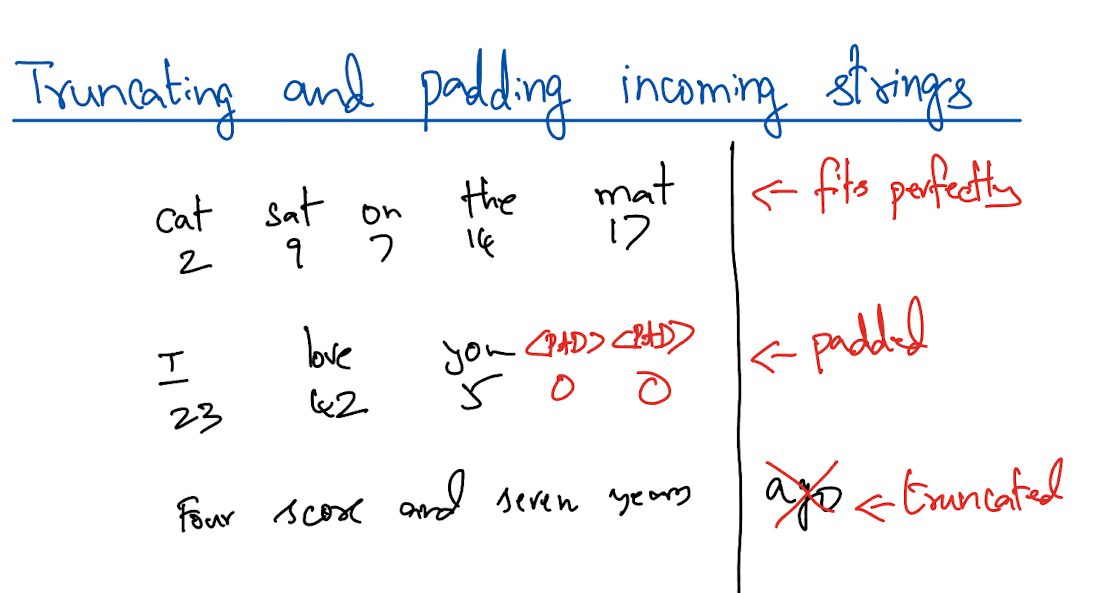

Next, let's run the training corpus through the `TextVectorization` layer to create the vocabulary.

In [ ]:
text_vectorization.adapt(train_df['Lyric'])

In [ ]:
text_vectorization.get_vocabulary()[:10]

['', '[UNK]', 'the', 'you', 'i', 'to', 'and', 'a', 'me', 'it']

**Important**: When `output_mode = int`, the vocabulary will use index 0 for the empty string "" and 1 for `[UNK]`. We will sometimes refer to the empty string as `[PAD]` since the index 0 is used to 'pad' short sentences to `max_length` (as shown in the picture above).

In [ ]:
text_vectorization(["HODL, you are the best!"])

<tf.Tensor: shape=(1, 300), dtype=int64, numpy=
array([[  1,   3,  58,   2, 258,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
   

Notice the use of `[UNK]` (i.e. index 1) and `[PAD]` (i.e., index 0) above.

Let's run all the datasets through to get the indexed version of each sentence in the datasets.

In [ ]:
X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

Next, the `Embedding` layer.

We first create a matrix from the GloVe embeddings we downloaded. This matrix will be used to initialize the `Embedding` layer.

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

counter = 0
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        counter += 1


The above code creates a lookup table that maps integers to the corresponding word vectors

In [ ]:
embedding_matrix.shape

(5000, 100)

The first two rows should be all zeros since they correspond to PAD and UNK.

In [ ]:
embedding_matrix[:3,:]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

Next, we will set up the Embedding layer.

In [ ]:
embedding_layer = keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True
)

Since we want to use the downloaded GLoVE embeddings, we have **initialized** the Embedding layer with the matrix we built earlier.

Like any other weights, the weights of an Embedding layer (its internal dictionary of token vectors) will get gradually adjusted via gradient descent (i.e., backpropagation) during training. But for starters, we want to keep them unchanged. So we added an extra argument `trainable=False` to freeze the layer to avoid disrupting these pretrained GLoVE embeddings during training.

We will discuss the role of `mask_zero=True` a bit later.

The flow so far:

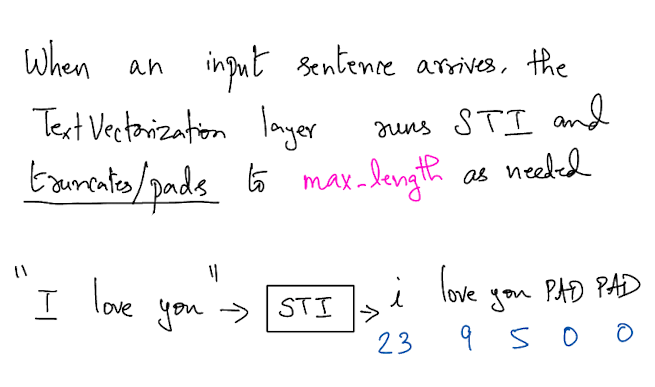

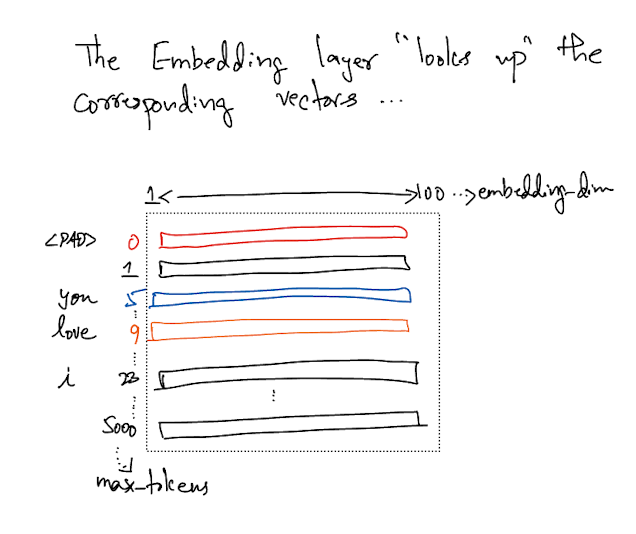

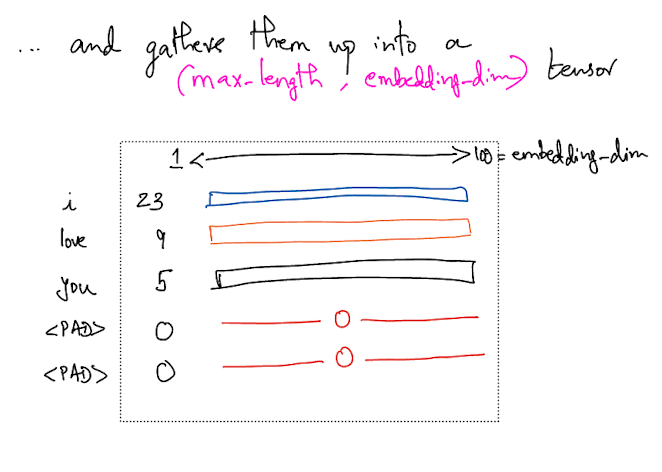

We are (finally!) ready to set up our NN model.

In [ ]:
inputs = keras.Input(shape=(max_length,))
embedded = embedding_layer(inputs) # 300 x 100 table comes out
embedded = keras.layers.GlobalAveragePooling1D()(embedded) # 100-element vector
x = keras.layers.Dense(8, activation='relu')(embedded) # only hidden layer
outputs = keras.layers.Dense(3, activation="softmax")(x) # output layer

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 100)          500000    
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
Total params: 500835 (1.91 MB)
Trainable params: 835 (3.26 KB)
Non-trainable params: 500000 (1.91 MB)
_________________________

Notice the `keras.layers.GlobalAveragePooling1D()` layer. As discussed in lecture, this does the following:


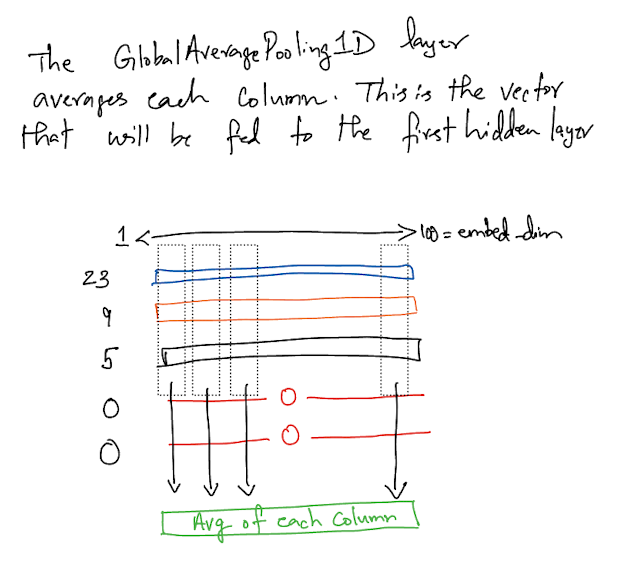

Let's take a look at the first few embedding vectors.

In [ ]:
emb = model.layers[1]
emb.weights

[<tf.Variable 'embedding/embeddings:0' shape=(5000, 100) dtype=float32, numpy=
 array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
          0.27062 ],
        ...,
        [ 0.33947 ,  0.16186 ,  0.083984, ..., -0.66934 , -0.073064,
          0.91467 ],
        [-0.09169 ,  0.10361 ,  0.23232 , ..., -0.13697 , -0.81738 ,
          0.3868  ],
        [ 0.28468 , -0.26489 ,  0.1649  , ..., -0.6158  , -0.10085 ,
          1.0357  ]], dtype=float32)>]

Notice that the first two vectors are all zeros. They correspond to the `[PAD]` and `[UNK]` tokens (equivalently, index 0 and 1) respectively. The other vectors are all from GloVe.

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model

history = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,)

Epoch 1/10
1531/1531 [==============================] - 7s 3ms/step - loss: 0.9270 - accuracy: 0.5487 - val_loss: 0.8888 - val_accuracy: 0.5556
Epoch 2/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.8617 - accuracy: 0.5836 - val_loss: 0.8370 - val_accuracy: 0.5957
Epoch 3/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.8306 - accuracy: 0.6059 - val_loss: 0.8134 - val_accuracy: 0.6205
Epoch 4/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.8113 - accuracy: 0.6173 - val_loss: 0.7979 - val_accuracy: 0.6270
Epoch 5/10
1531/1531 [==============================] - 6s 4ms/step - loss: 0.7986 - accuracy: 0.6259 - val_loss: 0.7961 - val_accuracy: 0.6275
Epoch 6/10
1531/1531 [==============================] - 6s 4ms/step - loss: 0.7912 - accuracy: 0.6325 - val_loss: 0.7822 - val_accuracy: 0.6374
Epoch 7/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.7861 - accuracy: 0.6336 - val_loss: 0.7819 - val_accuracy:

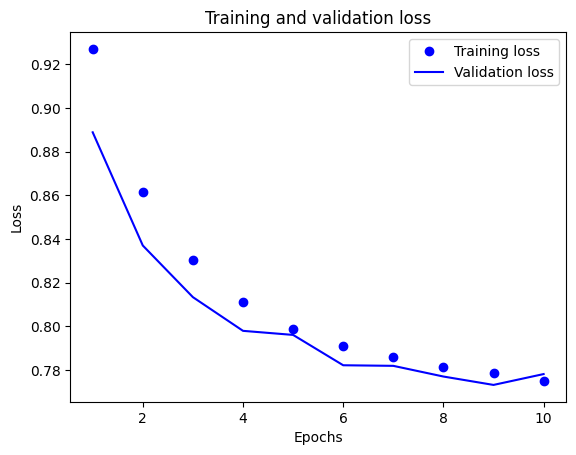

In [ ]:
plot_loss_curves(history)

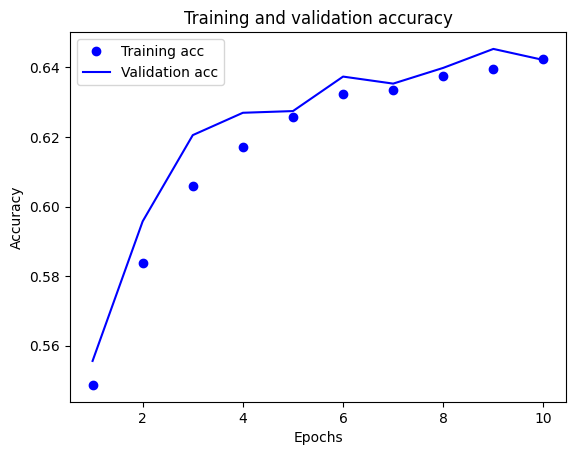

In [ ]:
plot_acc_curves(history)

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 1s 2ms/step - loss: 0.7939 - accuracy: 0.6320


[0.7938525676727295, 0.6319922804832458]

You’ll find that on this particular task, pretrained embeddings aren’t very helpful, because the dataset contains enough samples that it is possible to learn a good NN using just one-hot vectors from scratch. However, leveraging pretrained embeddings can be very helpful when you’re working with a smaller dataset.

Remember how we had set the `trainable` parameter to `False` when setting the embedding layer?  The `Embedding` layer weights should be unchanged, right? Let's check.


In [ ]:
emb = model.layers[1]
emb.weights

[<tf.Variable 'embedding/embeddings:0' shape=(5000, 100) dtype=float32, numpy=
 array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
          0.27062 ],
        ...,
        [ 0.33947 ,  0.16186 ,  0.083984, ..., -0.66934 , -0.073064,
          0.91467 ],
        [-0.09169 ,  0.10361 ,  0.23232 , ..., -0.13697 , -0.81738 ,
          0.3868  ],
        [ 0.28468 , -0.26489 ,  0.1649  , ..., -0.6158  , -0.10085 ,
          1.0357  ]], dtype=float32)>]

Good, it hasn't changed.

## Fine-tuning pretrained embeddings

What would happen if we let backprop update these weights as well? Will it help?

Let's find out!


In [ ]:
embedding_layer = keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True, # note that this has changed from before!!
    mask_zero=True
)

inputs = keras.Input(shape=(max_length,))
embedded = embedding_layer(inputs)
embedded = keras.layers.GlobalAveragePooling1D()(embedded)
x = keras.layers.Dense(8, activation='relu')(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 100)          500000    
                                                                 
 global_average_pooling1d_1  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                           

Let's take a look at the first few rows of the `Embedding` layer.

In [ ]:
emb = model.layers[1]
emb.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(5000, 100) dtype=float32, numpy=
 array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [-0.038194, -0.24487 ,  0.72812 , ..., -0.1459  ,  0.8278  ,
          0.27062 ],
        ...,
        [ 0.33947 ,  0.16186 ,  0.083984, ..., -0.66934 , -0.073064,
          0.91467 ],
        [-0.09169 ,  0.10361 ,  0.23232 , ..., -0.13697 , -0.81738 ,
          0.3868  ],
        [ 0.28468 , -0.26489 ,  0.1649  , ..., -0.6158  , -0.10085 ,
          1.0357  ]], dtype=float32)>]

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
# Fit model
history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,)

Epoch 1/10
1531/1531 [==============================] - 64s 41ms/step - loss: 0.8895 - accuracy: 0.5519 - val_loss: 0.7818 - val_accuracy: 0.6242
Epoch 2/10
1531/1531 [==============================] - 11s 7ms/step - loss: 0.7997 - accuracy: 0.6275 - val_loss: 0.7311 - val_accuracy: 0.6676
Epoch 3/10
1531/1531 [==============================] - 10s 6ms/step - loss: 0.7703 - accuracy: 0.6417 - val_loss: 0.7156 - val_accuracy: 0.6740
Epoch 4/10
1531/1531 [==============================] - 10s 7ms/step - loss: 0.7537 - accuracy: 0.6499 - val_loss: 0.7090 - val_accuracy: 0.6799
Epoch 5/10
1531/1531 [==============================] - 7s 5ms/step - loss: 0.7434 - accuracy: 0.6524 - val_loss: 0.7083 - val_accuracy: 0.6880
Epoch 6/10
1531/1531 [==============================] - 9s 6ms/step - loss: 0.7344 - accuracy: 0.6565 - val_loss: 0.7112 - val_accuracy: 0.6864
Epoch 7/10
1531/1531 [==============================] - 7s 5ms/step - loss: 0.7231 - accuracy: 0.6587 - val_loss: 0.6883 - val_accu

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 2s 2ms/step - loss: 0.6977 - accuracy: 0.6882


[0.6976873278617859, 0.688206136226654]

Training the GloVe embeddings with our data helps!

Let's confirm that the GloVe embeddings did get updated by backprop.

In [ ]:
emb = model.layers[1]
emb.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(5000, 100) dtype=float32, numpy=
 array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [-0.01803486,  0.01293981,  0.02621726, ...,  0.06944173,
         -0.03530286, -0.05263818],
        [ 0.02708609, -0.2885522 ,  0.68740726, ..., -0.04197716,
          0.67435586,  0.18884921],
        ...,
        [ 0.25000057,  0.22450046,  0.16026588, ..., -0.5401569 ,
         -0.1922127 ,  0.8581161 ],
        [ 0.33890453, -0.38242155, -0.19576748, ..., -0.09278595,
         -1.0223317 ,  0.23189624],
        [ 0.34597296, -0.3959639 ,  0.02459911, ..., -0.5034472 ,
         -0.14555253,  0.9440198 ]], dtype=float32)>]

Yes - the weights are different! Good!

**But note that the first vector of weights - corresponding to `[PAD]` - was all zeros before training and it is still zeros. How come backprop didn't update it?**

This is by design. The `[PAD]` tokens don't have any meaning. We use them just so that all sentences have the same length (which makes it very efficient to do matrix multiplication). We don't want them included in the loss function calculation and backprop etc. By setting `mask_zero=True` when we create the `Embedding` layer, we tell Keras to ignore `[PAD]`s in backprop. That's why the all-zero vector corresponding to `[PAD]` is still all zero. It is untouched by backprop and that's by design.


If using the information from the text to further adjust the weights of the pretrained embedding helps, why not just learn an embedding from scratch then?



## Learning embeddings from scratch

We can easily do this by adding a fresh Embedding layer to the net, specifying in this case what the output dimension will be (i.e., the size of the embedding space). We choose 64.

In [ ]:
inputs = keras.Input(shape=(max_length,))

embedded = keras.layers.Embedding(input_dim=max_tokens,
                                  output_dim=64,
                                  mask_zero=True)(inputs)

embedded = keras.layers.GlobalAveragePooling1D()(embedded)

x = keras.layers.Dense(16, activation='relu')(embedded)

x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 300, 64)           320000    
                                                                 
 global_average_pooling1d_2  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                           

In [ ]:
emb = model.layers[1]
emb.weights

[<tf.Variable 'embedding_2/embeddings:0' shape=(5000, 64) dtype=float32, numpy=
 array([[ 0.03988674, -0.01046743,  0.04392498, ...,  0.04452335,
          0.00331632, -0.01236486],
        [ 0.04284854, -0.00047932,  0.00756479, ..., -0.04712193,
         -0.01650797, -0.00690433],
        [-0.00249736,  0.04027966, -0.01198497, ..., -0.03992665,
          0.02903581,  0.0292636 ],
        ...,
        [ 0.04256946, -0.00146491, -0.00018871, ...,  0.00194367,
          0.0028968 ,  0.03072479],
        [-0.03107336,  0.02848836, -0.03944105, ...,  0.00154791,
          0.0042918 ,  0.01791209],
        [ 0.01966998, -0.04634146, -0.02410214, ..., -0.02489544,
         -0.01993065, -0.03037566]], dtype=float32)>]

Unlike before, the first two vectors are not all zeros. The first vector can be **anything** (since it won't be used in backprop) and since we will be updating the `[UNK]' vector with backprop, we can use random starting values for it.

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32,)

Epoch 1/10
1531/1531 [==============================] - 57s 37ms/step - loss: 0.7853 - accuracy: 0.6339 - val_loss: 0.6588 - val_accuracy: 0.6983
Epoch 2/10
1531/1531 [==============================] - 11s 7ms/step - loss: 0.6755 - accuracy: 0.6904 - val_loss: 0.6374 - val_accuracy: 0.7156
Epoch 3/10
1531/1531 [==============================] - 9s 6ms/step - loss: 0.6446 - accuracy: 0.7060 - val_loss: 0.6326 - val_accuracy: 0.7147
Epoch 4/10
1531/1531 [==============================] - 9s 6ms/step - loss: 0.6219 - accuracy: 0.7155 - val_loss: 0.6345 - val_accuracy: 0.7125
Epoch 5/10
1531/1531 [==============================] - 7s 4ms/step - loss: 0.6079 - accuracy: 0.7290 - val_loss: 0.6381 - val_accuracy: 0.7184
Epoch 6/10
1531/1531 [==============================] - 8s 5ms/step - loss: 0.5927 - accuracy: 0.7363 - val_loss: 0.6431 - val_accuracy: 0.7169
Epoch 7/10
1531/1531 [==============================] - 7s 5ms/step - loss: 0.5789 - accuracy: 0.7411 - val_loss: 0.6509 - val_accura

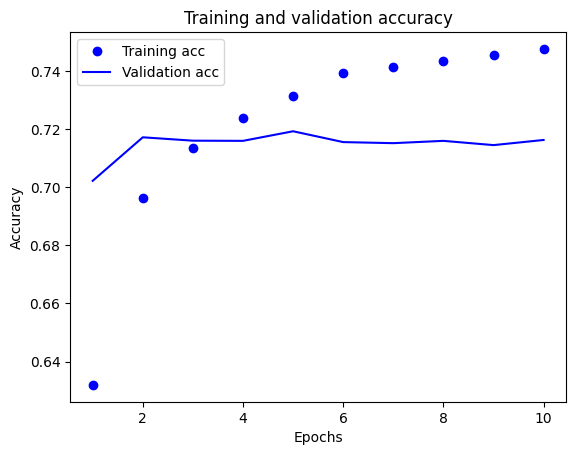

In [ ]:
plot_acc_curves(history)

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 1s 2ms/step - loss: 0.7050 - accuracy: 0.7137


[0.7049952149391174, 0.7137411832809448]

Accuracy is slightly better than using pretrained embeddings and the number of trainable parameters is much smaller. By playing with the dimension of the embeddings and the # of neurons in the hidden unit, we may be able to improve it even further.


Let's wrap up with a quick look at the final values of a few embeddings.

In [ ]:
emb = model.layers[1]
emb.weights

[<tf.Variable 'embedding_3/embeddings:0' shape=(5000, 64) dtype=float32, numpy=
 array([[ 0.04956419, -0.03067314,  0.03253037, ...,  0.01102392,
         -0.03788554, -0.0165463 ],
        [ 0.04675195,  0.01391668, -0.03809964, ..., -0.01741756,
         -0.01075476, -0.02445586],
        [ 0.00520377,  0.03241806, -0.05720215, ..., -0.00596667,
         -0.00840447, -0.01725002],
        ...,
        [-0.37923124, -0.06925657,  0.3226616 , ...,  0.00869293,
          0.14842917,  0.18332942],
        [ 0.3052145 , -0.29535967, -0.40155807, ..., -0.31318322,
         -0.37514752, -0.47290623],
        [ 0.98114264,  0.21740673, -0.9737473 , ...,  0.07688604,
         -0.02054078, -0.45234516]], dtype=float32)>]

Note that all the vectors except the first one have changed. The first vector corresponds to `[PAD]`, which, by design, is excluded from backprop with the `mask_zero` flag.



---

**Remember**

If you have "plenty" of data, pretrained embeddings may not help (although it is still worth a try). But they can be very beneficial when you don't have a lot of data.



---




